In [1]:
import numpy as np 
import FlowCytometryTools
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import FCPlate
from FlowCytometryTools import ThresholdGate, PolyGate
import matplotlib.pyplot as plt
import scipy as sp
import scipy.special
import seaborn as sns
import pandas as pd
import datetime as dt

FSCHgateupper = ThresholdGate(6550.0, ['FSC-H'], region='below')
FSCHgatelower = ThresholdGate(5100.0, ['FSC-H'], region='above')
SSCHgatelower = ThresholdGate(4800.0, ['SSC-H'], region='above') 
SSCHgateupper = ThresholdGate(5600.0, ['SSC-H'], region='below')
scatter_gates = FSCHgateupper & FSCHgatelower & SSCHgatelower & SSCHgateupper


bfp_threshold = [[{"A1":7425,"A3":7425,"C1":7425,"C3":7425,"B1":7570,"B3":7570,"D1":7650,"D3":7750,"E1":7550,"E3":7495}],
                 [{"A1":7425,"A3":7425,"C1":7475,"C3":7475,"B1":7570,"B3":7570,"D1":7600,"D3":7600,"E1":7600,"E3":7600},
                  {"A1":7425,"A3":7425,"C1":7425,"C3":7450,"B1":7570,"B3":7570,"D1":7600,"D3":7700,"E1":7600,"E3":7500},
                  {"A1":7450,"A3":7425,"C1":7450,"C3":7450,"B1":7600,"B3":7600,"D1":7800,"D3":7800,"E1":7600,"E3":7500}]]
yfp_threshold = 6150

days = list(range(2))
plate_num = list(range(1,4))
plates = {}

for day in days:
    list_plates = []
    datadir = '/Users/kristenlok/Desktop/2.8.22_monoculture_flucts/D{}/'.format(str(day))
    if day == 1:
        for p in plate_num:
            datadir = '/Users/kristenlok/Desktop/2.8.22_monoculture_flucts/D1/p{}/'.format(str(p))
            plate = FCPlate.from_dir(ID='96-well', path=datadir, parser='name')
            plate_transformed = plate.transform('hlog', channels=['BFP-H','YFP-H'], b=100.0).transform('hlog', channels=['FSC-H','SSC-H'], b=10.0**2).gate(scatter_gates)
            list_plates.append(plate_transformed)
    else:
        plate = FCPlate.from_dir(ID='96-well', path=datadir, parser='name')
        plate_transformed = plate.transform('hlog', channels=['BFP-H','YFP-H'], b=100.0).transform('hlog', channels=['FSC-H','SSC-H'], b=10.0**2).gate(scatter_gates)
        list_plates.append(plate_transformed) 
    plates[day] = list_plates
    

/Users/kristenlok/opt/anaconda3/lib/python3.8/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/Users/kristenlok/opt/anaconda3/lib/python3.8/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/Users/kristenlok/opt/anaconda3/lib/python3.8/site-packages/FlowCytometryTools/core/transforms.py:180: RuntimeWarning: divide by zero encountered in log10
  lxmin = max([log10(abs(xmin)), 0])


In [2]:
def f1_expectation(theta,f1obs_data,f2obs_data,nmax=100):
    f1,lam = theta
    f2=1-f1
    f1obs=0
    f2obs=0
    for k in range(1,nmax):
        f1obs+=((f1*lam)**k)/scipy.special.factorial(k)/(np.exp(lam)-1)
        f2obs+=((f2*lam)**k)/scipy.special.factorial(k)/(np.exp(lam)-1)
    return f1obs-f1obs_data, f2obs-f2obs_data


def get_bfp_freq(data, day, plate_num, well):
    bfp_pos = data['BFP-H']>bfp_threshold[day][plate_num][well]
    yfp_pos = data['YFP-H']>yfp_threshold
    bfp_neg = data['BFP-H']<bfp_threshold[day][plate_num][well]
    yfp_neg = data['YFP-H']<yfp_threshold

    bfp = len(data[bfp_pos & yfp_neg])
    yfp = len(data[yfp_pos & bfp_neg])
    dp = len(data[bfp_pos & yfp_pos])
    Q = bfp + yfp + dp
    func = lambda theta: f1_expectation(theta,bfp/Q,yfp/Q)
    res = sp.optimize.root(func, [bfp/Q, 0.5])

    bfp_mean = np.float(data[bfp_pos & yfp_neg]['BFP-H'].mean())
    yfp_mean = np.float(data[yfp_pos & bfp_neg]['YFP-H'].mean())
    return res.x, Q, bfp_mean, yfp_mean

[[<FCOrderedCollection '96-well'>], [<FCOrderedCollection '96-well'>, <FCOrderedCollection '96-well'>, <FCOrderedCollection '96-well'>]]


/Users/kristenlok/opt/anaconda3/lib/python3.8/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


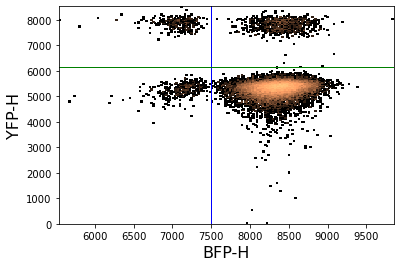

In [3]:
b_gate = ThresholdGate(7495, ['BFP-H'], region='above')
y_gate = ThresholdGate(6150, ['YFP-H'], region='above')


all_plates = list(plates.values())
print(all_plates)
for plate in all_plates:
    all_plates[0][0]['E3'].plot(['BFP-H', 'YFP-H'], gates=[b_gate, y_gate])


In [4]:
def plot_plates(day, plate_num, well, bfp_threshold, yfp_threshold):
    b_gate = ThresholdGate(bfp_threshold[day][plate_num][well], ['BFP-H'], region='above')
    all_plates = list(plates.values())
    for plate in all_plates:
        all_plates[day][plate_num][well].plot(['BFP-H', 'YFP-H'], gates=[b_gate, y_gate])
                

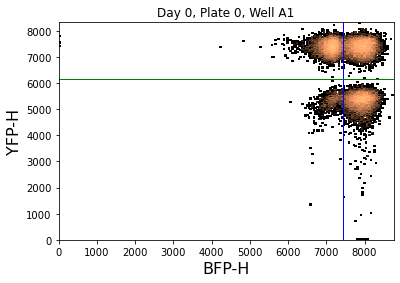

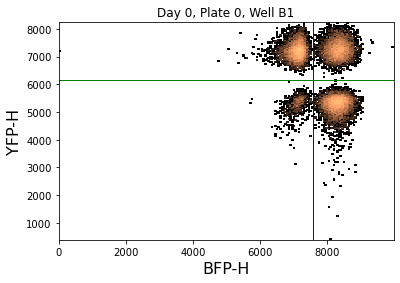

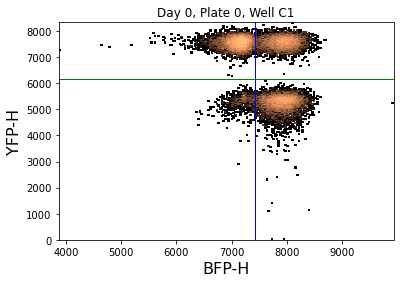

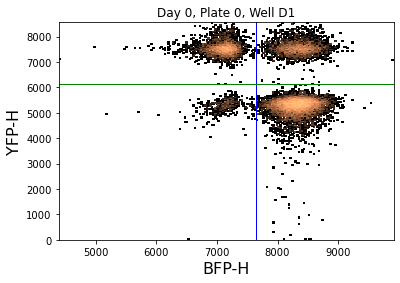

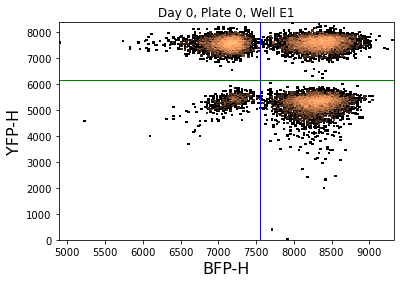

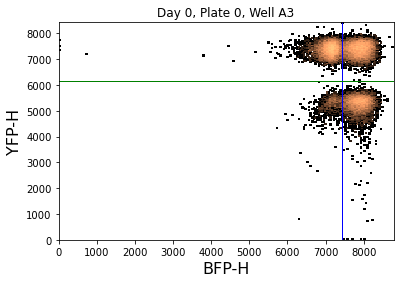

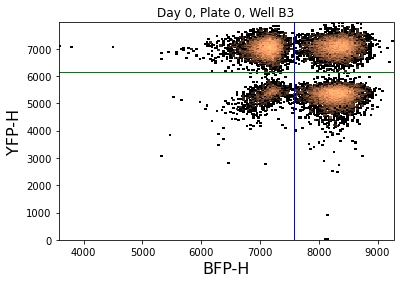

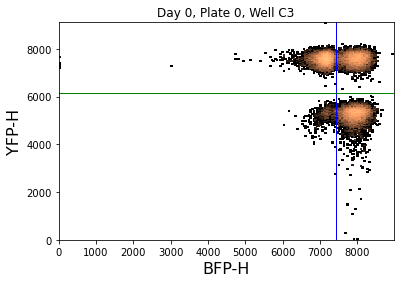

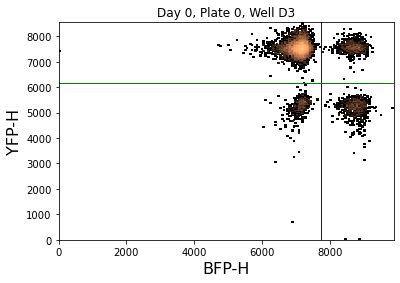

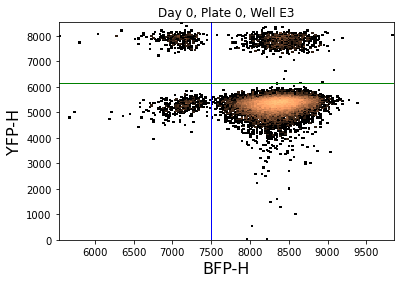

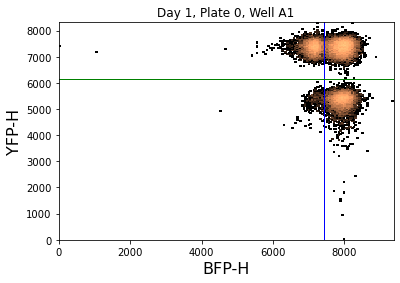

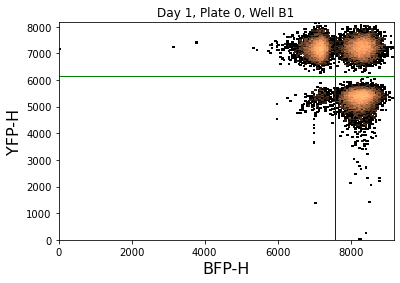

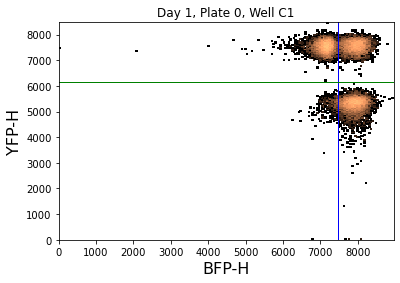

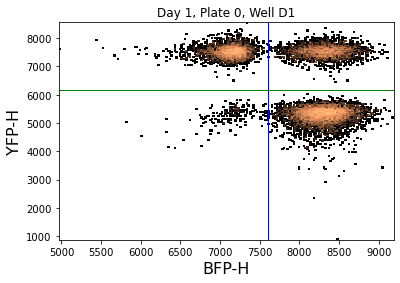

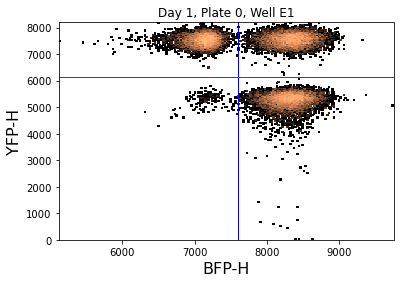

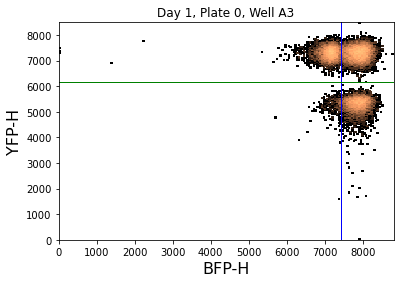

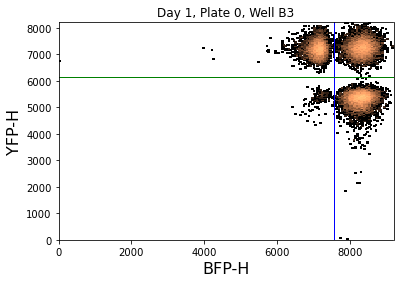

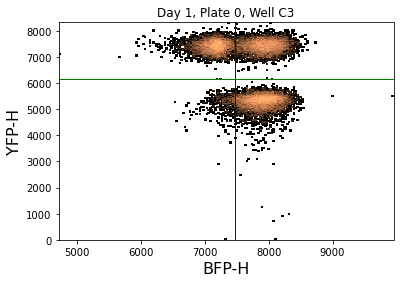

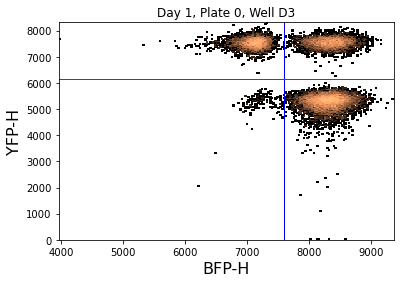

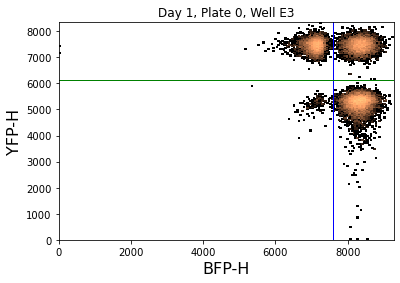

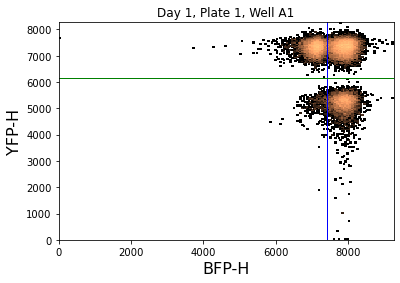

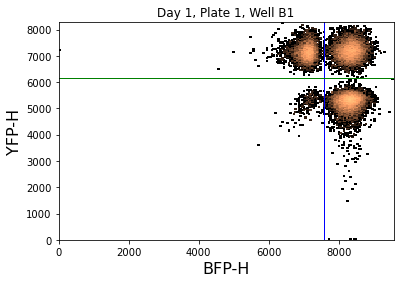

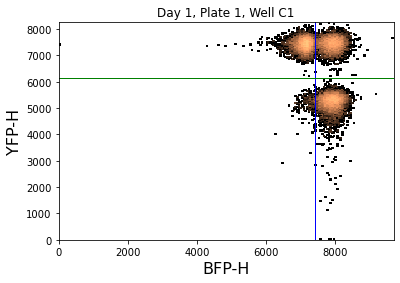

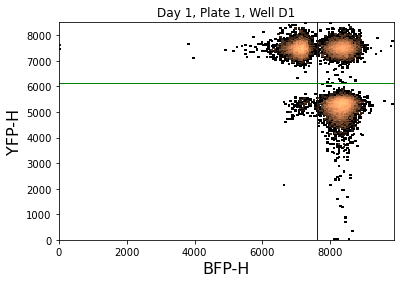

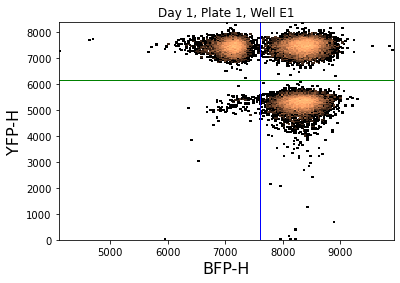

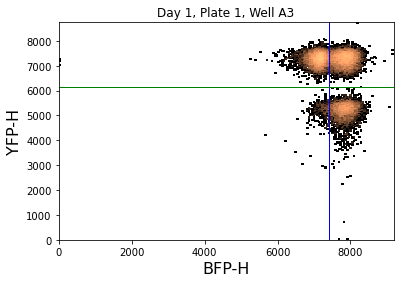

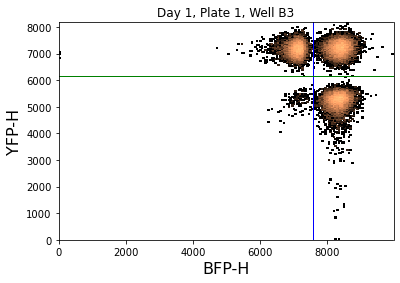

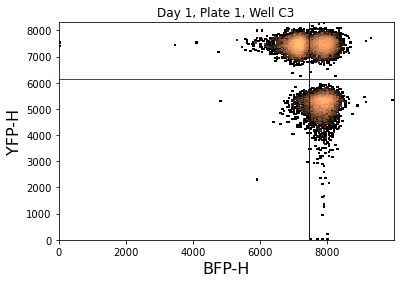

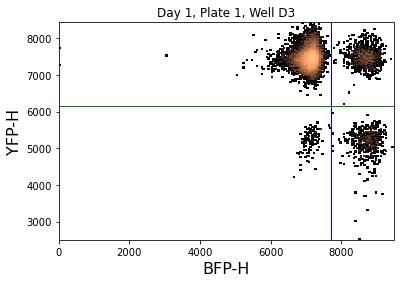

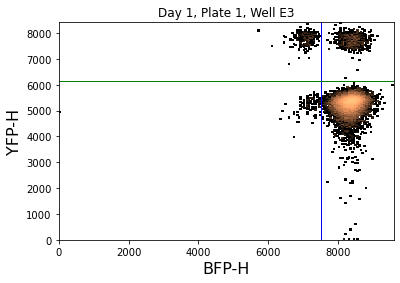

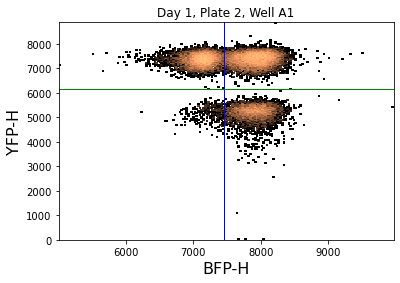

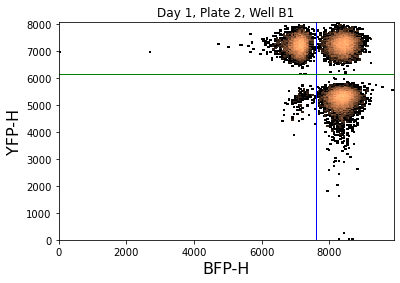

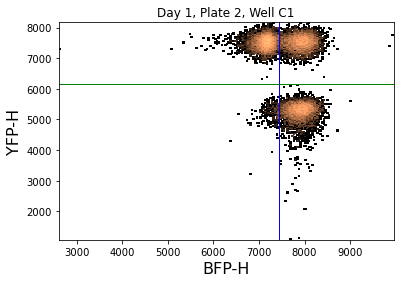

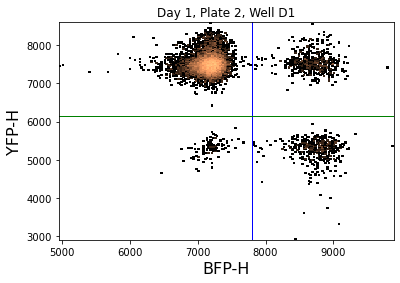

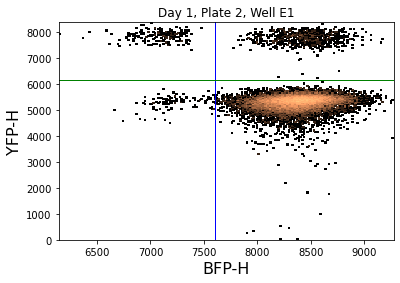

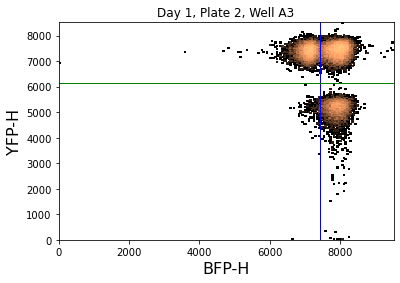

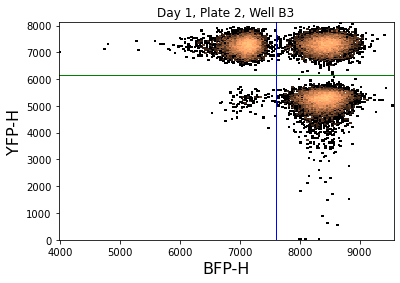

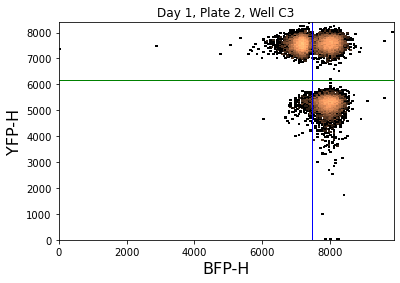

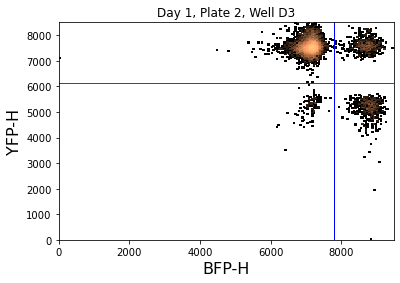

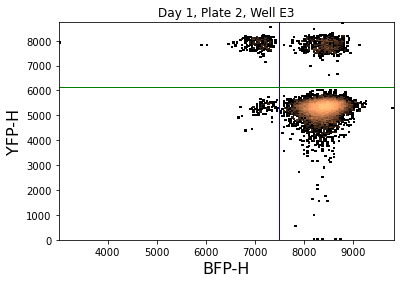

In [5]:
wells = ['A1','B1','C1','D1','E1','A3','B3','C3','D3','E3']

for day in days:
    for plate in plates[day]:
        for well in wells:
            #well = row + str(col)
            plt.figure()
            plot_plates(day, plates[day].index(plate), well, bfp_threshold, yfp_threshold)
            plt.title('Day %d, Plate %d, Well %s' % (day, plates[day].index(plate), well))
            plt.show()

In [6]:
b_data=[]

cols = [1,3]
rows = ['A','B','C','D','E']

for day in days:
    for row in rows:
        for col in cols:
            for plate in plates[day]:
                well = row + str(col)
                well_sort = str(col) + row
                try:
                    #res,Q,bfp,yfp = get_bfp_freq(plate[well].data, well)
                    res,Q,bfp,yfp = get_bfp_freq(plate[well].data, day, plates[day].index(plate), well)
                except:
                    continue
                if day == 0 and col == 1:
                    group = "A-G1-3"
                if day == 0 and col == 3:  
                    group = "A-E4-6"
                if day == 1 and plates[day].index(plate)+1 == 1:
                    group = "A-G1-3"
                if day == 1 and plates[day].index(plate)+1 == 2:
                    if col == 1:
                        group = "A-G1-3" 
                    if col == 3:
                        group = "A-E4-6"
                if day == 1 and plates[day].index(plate)+1 == 3:
                    group = "A-E4-6"
                    
                b_data.append({
                    'day':day,
                    'plate':plates[day].index(plate)+1,
                    'well':well,
                    'sort by well': well_sort,
                    'group': group,
                    'S freq': res[0],
                    'lambda': res[1],
                    'total count':Q,
                    'corrected total count': Q*res[1]/(1-np.exp(-res[1])),
                    'BFP':bfp,
                    'YFP':yfp,
                })     
            
df = pd.DataFrame(b_data)
df.sort_values(['day','plate', 'sort by well'])
#df.head()

,day,plate,well,sort by well,group,S freq,lambda,total count,corrected total count,BFP,YFP
0,0,1,A1,1A,A-G1-3,0.503408,1.608840,27560,55432.822095,7932.292480,7394.950195
2,0,1,B1,1B,A-G1-3,0.522032,1.215995,24357,42095.817541,8305.466797,7220.174316
4,0,1,C1,1C,A-G1-3,0.474910,1.157313,23267,39271.350150,7920.224609,7568.151367
6,0,1,D1,1D,A-G1-3,0.685507,0.875676,18853,28297.159687,8328.185547,7543.209473
8,0,1,E1,1E,A-G1-3,0.540542,1.535194,18688,36566.669491,8294.299805,7555.507812
1,0,1,A3,3A,A-E4-6,0.454519,1.631523,28073,56941.233894,7893.655273,7391.569824
3,0,1,B3,3B,A-E4-6,0.521518,1.380176,20499,37800.303670,8287.263672,7029.733887
5,0,1,C3,3C,A-E4-6,0.505646,1.256911,24382,42833.486024,7957.366211,7571.678711
7,0,1,D3,3D,A-E4-6,0.076558,0.778706,14966,21541.783406,8757.857422,7552.244629
9,0,1,E3,3E,A-E4-6,0.968928,1.420628,23167,43394.054158,8357.493164,7871.955566


In [7]:
def get_freqncount(df, days, group, row): #where rowA=229+231, rowB = 246+247, rowC = 248+249, rowD=245+246, rowE=246+249
    freq_dict = {}
    count_dict = {}
    freq_list = []
    count_list = []
    for day in days:
        df_day = df.loc[df['day'] == day]
        freq_rep = []
        count_rep = []
        for i in range(len(df_day)):
            if df_day.iloc[i,4] == group and df_day.iloc[i,2][0] == row:
                freq = df_day.iloc[i,5] #S_freq index = 5
                freq_rep.append(freq)
                count = df_day.iloc[i,8] #corrected total count index = 8
                count_rep.append(count)
        freq_list.append(freq_rep)
        count_list.append(count_rep)
    freq_dict[group + "_" + row] = freq_list
    count_dict[group + "_" + row] = count_list
    return freq_dict, count_dict
            

In [8]:
groups = ["A-G1-3","A-E4-6"]
rows = ["A","B","C","D","E"]

all_freqs = []
all_counts = []
for group in groups:
    for row in rows:
        freq, count = get_freqncount(df, days, group, row)
        all_freqs.append(freq)
        all_counts.append(count)
        
print(all_freqs)
print(all_counts)

[{'A-G1-3_A': [[0.5034075533603082], [0.5362323559500088, 0.463714663295056, 0.4955376729652408]]}, {'A-G1-3_B': [[0.5220318216950397], [0.546383095225296, 0.5936356249325427, 0.572230898940029]]}, {'A-G1-3_C': [[0.4749098809011338], [0.5202217046147679, 0.5168331223512808, 0.5633310010583796]]}, {'A-G1-3_D': [[0.6855074591203497], [0.622967589377451, 0.5990845715022268, 0.6405117149742201]]}, {'A-G1-3_E': [[0.5405416323433293], [0.5396736268995954, 0.5604639241470881, 0.6188389241621689]]}, {'A-E4-6_A': [[0.45451906635434103], [0.4216397496373794, 0.4193682002740638, 0.43057840946998555]]}, {'A-E4-6_B': [[0.5215180304537286], [0.5586448950153032, 0.5424116816605559, 0.5460573089580587]]}, {'A-E4-6_C': [[0.5056459553468189], [0.491705963000347, 0.48280412216366636, 0.49599697485746846]]}, {'A-E4-6_D': [[0.07655804975334195], [0.07120739409112226, 0.06326975773880464, 0.0747946252306008]]}, {'A-E4-6_E': [[0.96892833929698], [0.9772248269403314, 0.9757727976966771, 0.9712830552043594]]}]

In [9]:
def vst(df, days, group, row):
    df_day = df.loc[df['day'] == 1]
    vst_dict = {}
    all_vst = []
    for i in range(len(df_day)):
        if df_day.iloc[i,4] == group and df_day.iloc[i,2][0] == row:
            corr_count = df_day.iloc[i,8]
            bfp = df_day.iloc[i,9]
            yfp = df_day.iloc[i,10]
            bfp_freq = bfp/(bfp+yfp)
            f_trafo = np.sqrt(corr_count)*np.arcsin(2*bfp_freq - 1)
            all_vst.append(f_trafo)
    vst_dict[group + "_" + row] = all_vst
    return vst_dict


def vst_var(all_vsts):
    group_list = []
    vst_list = []
    var_list = []
    for dictionary in all_vsts:
        group = list(dictionary.keys())[0]
        group_list.append(group)
        vsts = list(dictionary.values())[0]
        vst_list.append(vsts)
        vst_var = np.var(vsts)
        var_list.append(vst_var)
    return group_list, vst_list, var_list

    
    

In [10]:
groups = ["A-G1-3","A-E4-6"]
rows = ["A","B","C","D","E"]

all_vsts = []
for group in groups:
    for row in rows:
        vst_d = vst(df, days, group, row)
        all_vsts.append(vst_d)
print(all_vsts)

[{'A-G1-3_A': [9.283715276452256, 9.81830385048504, 9.154196592788129]}, {'A-G1-3_B': [14.69360874045392, 16.613439130822343, 14.616999469679689]}, {'A-G1-3_C': [5.047463207196564, 6.705879763742064, 6.2214270934160725]}, {'A-G1-3_D': [7.936619185759089, 10.340883987786349, 8.603469586822733]}, {'A-G1-3_E': [10.266875208114307, 12.669037350161553, 10.975299271683319]}, {'A-E4-6_A': [8.793738352071934, 9.147950093262699, 9.557324462511898]}, {'A-E4-6_B': [16.19029383492764, 17.406506321066605, 16.130652593978017]}, {'A-E4-6_C': [5.017635817394373, 5.959757487806182, 5.196134201711727]}, {'A-E4-6_D': [9.538137025630586, 13.643676084983397, 11.19570145345509]}, {'A-E4-6_E': [6.577466571786652, 7.186081576521473, 6.0161718042279455]}]


In [11]:
title_dict = {"A-G1-3_A":"REL 606 BFP:REL 606 YFP 50:50, daily mix", 
              "A-G1-3_B":"S BFP:S YFP 50:50, daily mix",
              "A-G1-3_C":"Sl1 BFP:Sl1YFP 50:50, daily mix", 
              "A-G1-3_D":"S BFP:L YFP 50:50, daily mix",
              "A-G1-3_E":"S BFP:Sl1 YFP 50:50, daily mix",
              "A-E4-6_A":"REL 606 BFP:REL 606 YFP 50:50, premixed",
              "A-E4-6_B":"S BFP:S YFP 50:50, premixed",
              "A-E4-6_C":"Sl1 BFP:Sl1YFP 50:50, premixed",
              "A-E4-6_D":"S BFP:L YFP 5:95, premixed",
              "A-E4-6_E":"S BFP:Sl1 YFP 95:5, premixed"}

titles = []
group_list, vst_list, var_list = vst_var(all_vsts)
for group in group_list:
    titles.append(title_dict[group])
    
df_vstvar = pd.DataFrame({'group' : titles, 'f_{trafo} replicates' : vst_list, 'var(f_{trafo})' : var_list})
df_vstvar.head(12)

,group,f_{trafo} replicates,var(f_{trafo})
0,"REL 606 BFP:REL 606 YFP 50:50, daily mix","[9.283715276452256, 9.81830385048504, 9.154196...",0.082622
1,"S BFP:S YFP 50:50, daily mix","[14.69360874045392, 16.613439130822343, 14.616...",0.853043
2,"Sl1 BFP:Sl1YFP 50:50, daily mix","[5.047463207196564, 6.705879763742064, 6.22142...",0.484803
3,"S BFP:L YFP 50:50, daily mix","[7.936619185759089, 10.340883987786349, 8.6034...",1.027087
4,"S BFP:Sl1 YFP 50:50, daily mix","[10.266875208114307, 12.669037350161553, 10.97...",1.015666
5,"REL 606 BFP:REL 606 YFP 50:50, premixed","[8.793738352071934, 9.147950093262699, 9.55732...",0.097346
6,"S BFP:S YFP 50:50, premixed","[16.19029383492764, 17.406506321066605, 16.130...",0.345615
7,"Sl1 BFP:Sl1YFP 50:50, premixed","[5.017635817394373, 5.959757487806182, 5.19613...",0.166953
8,"S BFP:L YFP 5:95, premixed","[9.538137025630586, 13.643676084983397, 11.195...",2.843950
9,"S BFP:Sl1 YFP 95:5, premixed","[6.577466571786652, 7.186081576521473, 6.01617...",0.228239


In [12]:
title_dict = {"A-G1-3_A":"REL 606 BFP:REL 606 YFP 50:50, daily mix", 
              "A-G1-3_B":"S BFP:S YFP 50:50, daily mix",
              "A-G1-3_C":"Sl1 BFP:Sl1YFP 50:50, daily mix", 
              "A-G1-3_D":"S BFP:L YFP 50:50, daily mix",
              "A-G1-3_E":"S BFP:Sl1 YFP 50:50, daily mix",
              "A-E4-6_A":"REL 606 BFP:REL 606 YFP 50:50, premixed",
              "A-E4-6_B":"S BFP:S YFP 50:50, premixed",
              "A-E4-6_C":"Sl1 BFP:Sl1YFP 50:50, premixed",
              "A-E4-6_D":"S BFP:L YFP 5:95, premixed",
              "A-E4-6_E":"S BFP:Sl1 YFP 95:5, premixed"}

def plot_freqs(group, all_freqs):
    days = [0,1]
    for dictionary in all_freqs:
        if list(dictionary.keys())[0] == group:
            for value in dictionary.values():
                avg_y = [value[0][0], np.mean(value[1])]
                p = sns.lineplot(x=days,y=avg_y,label='Average')
                for i in range(0,3):
                    freq_y = [value[0][0], value[1][i]]
                    p = sns.lineplot(x=days,y=freq_y,label='Replicate')
    p.set(xlabel = "Days", ylabel = "BFP Frequency", xticks=([0, 1]), title=title_dict[group] + " Frequency")
    plt.show()

def plot_counts(group, all_counts):
    days = [0,1]
    for dictionary in all_counts:
        if list(dictionary.keys())[0] == group:
            for value in dictionary.values():
                avg_y = [value[0][0], np.mean(value[1])]
                p = sns.lineplot(x=days,y=avg_y,label='Average')
                for i in range(0,3):
                    freq_y = [value[0][0], value[1][i]]
                    p = sns.lineplot(x=days,y=freq_y,label='Replicate')
    p.set(xlabel = "Days", ylabel = "Corrected counts", xticks=([0, 1]), title=title_dict[group] + " Counts")
    plt.show()

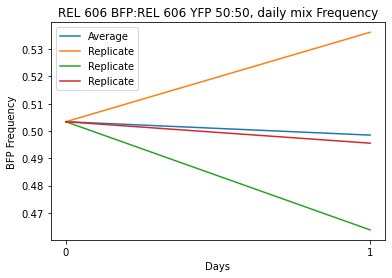

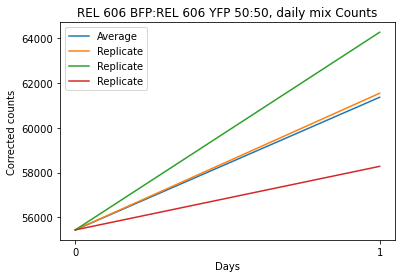

In [13]:
plot_freqs("A-G1-3_A",all_freqs)
plot_counts("A-G1-3_A",all_counts)

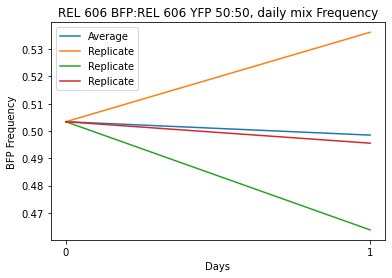

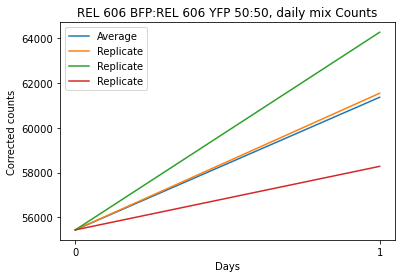

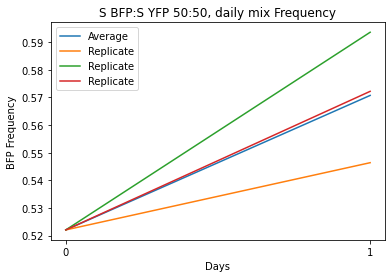

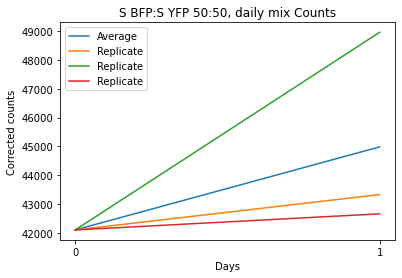

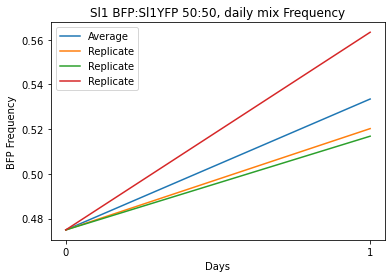

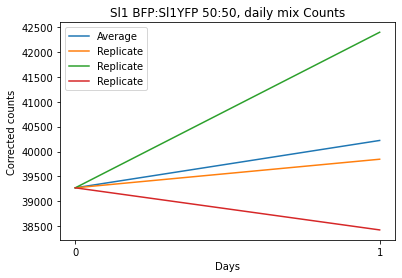

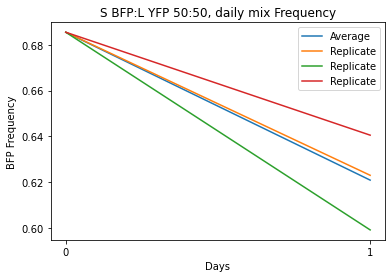

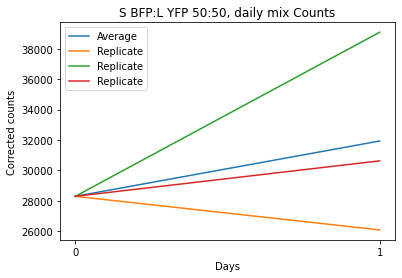

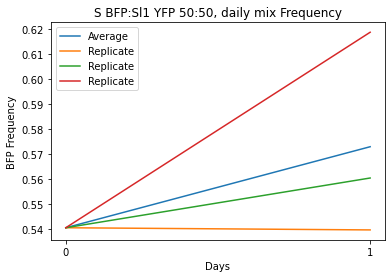

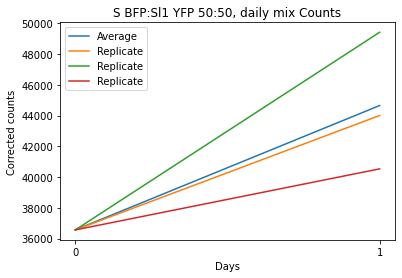

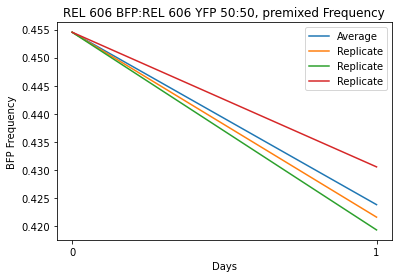

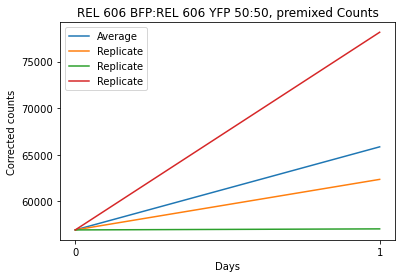

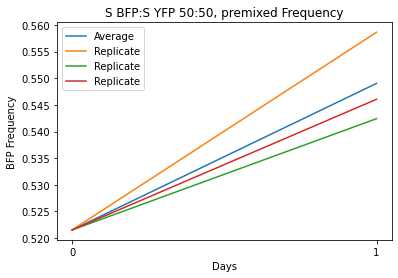

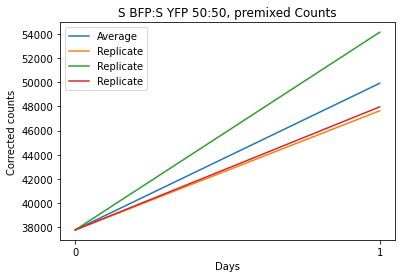

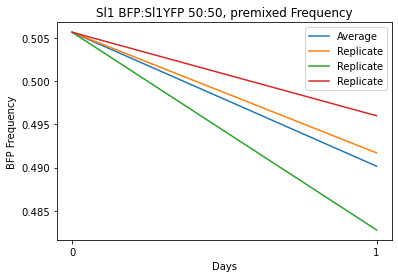

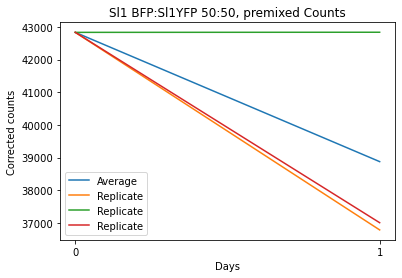

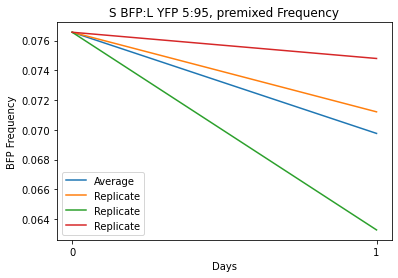

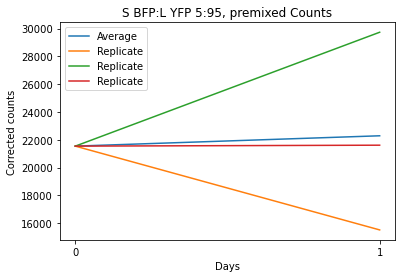

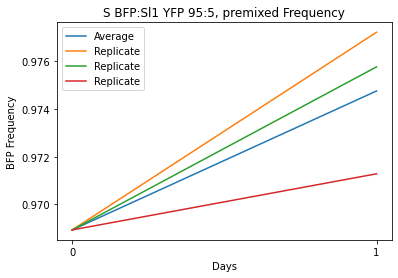

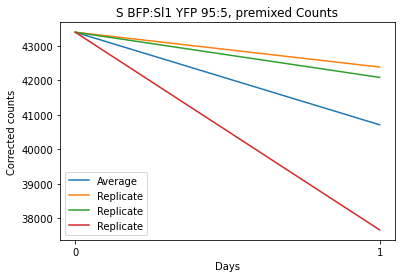

In [14]:
keys = []
for dictionary in all_freqs:
    keys.append(list(dictionary.keys())[0])

for key in keys:
    plot_freqs(key, all_freqs)
    plot_counts(key, all_counts)

In [15]:
#Day0: 2.7.22 to 2.8.22 at 15:30pm 
#Day1: 2.8.22 at 16:00pm to 2.9.22 at 15:30pm

df_temp = pd.read_csv('/Users/kristenlok/Desktop/Indoor_Thermometer.csv')
df_temp.columns.values[0] = "Date and Timestamp"
df_temp.columns.values[1] = "Temperature"
df_temp.columns.values[2] = "Humidity"

df_td0 = df_temp.copy()
df_td0 = df_td0.loc[(df_td0['Date and Timestamp'] >= '2022-02-07 08:47:00') & (df_td0['Date and Timestamp'] <= '2022-02-08 15:30:00')]
df_td0.head(50)



,Date and Timestamp,Temperature,Humidity
0,2022-02-07 08:47:00,36.9,17.4
1,2022-02-07 08:48:00,36.9,17.4
2,2022-02-07 08:49:00,36.9,17.5
3,2022-02-07 08:50:00,36.9,17.5
4,2022-02-07 08:51:00,36.9,17.5
5,2022-02-07 08:52:00,36.9,17.5
6,2022-02-07 08:53:00,36.9,17.5
7,2022-02-07 08:54:00,36.9,17.6
8,2022-02-07 08:55:00,37.0,17.6
9,2022-02-07 08:56:00,37.0,17.6


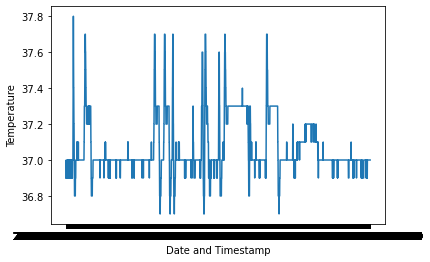

In [16]:
sns.lineplot(df_temp["Date and Timestamp"], df_temp["Temperature"])

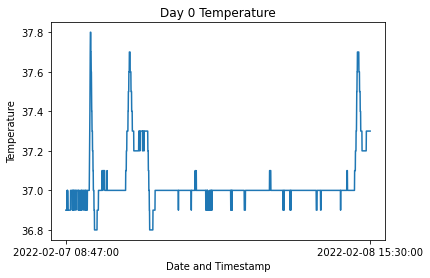

In [17]:

d0t = sns.lineplot(x='Date and Timestamp',y='Temperature',data=df_td0).set(title='Day 0 Temperature',xticks=(['2022-02-07 08:47:00', '2022-02-08 15:30:00']))



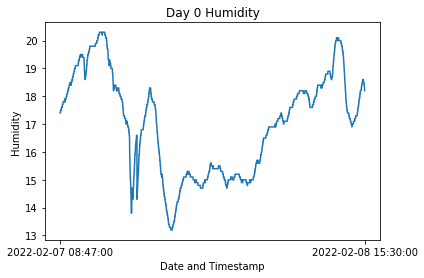

In [18]:
d0h = sns.lineplot(x='Date and Timestamp',y='Humidity',data=df_td0).set(title='Day 0 Humidity',xticks=(['2022-02-07 08:47:00', '2022-02-08 15:30:00']))


In [19]:
df_td1 = df_temp.copy()
df_td1 = df_td1.loc[(df_td1['Date and Timestamp'] >= '2022-02-08 16:00:00') & (df_td1['Date and Timestamp'] <= '2022-02-09 15:30:00')]
df_td1.head()


,Date and Timestamp,Temperature,Humidity
1873,2022-02-08 16:00:00,36.8,18.3
1874,2022-02-08 16:01:00,36.8,18.3
1875,2022-02-08 16:02:00,36.8,18.2
1876,2022-02-08 16:03:00,36.7,18.0
1877,2022-02-08 16:04:00,36.7,17.9


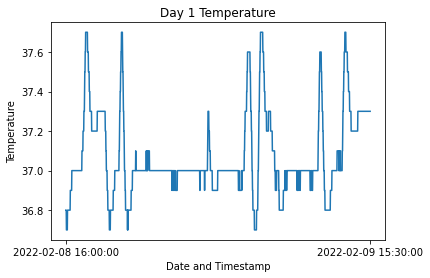

In [20]:
d1t = sns.lineplot(x='Date and Timestamp',y='Temperature',data=df_td1).set(title='Day 1 Temperature',xticks=(['2022-02-08 16:00:00', '2022-02-09 15:30:00']))



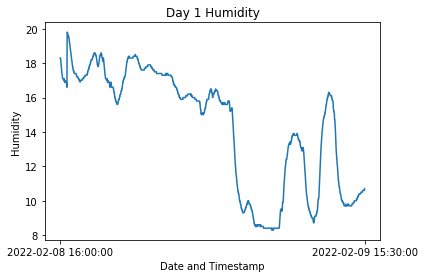

In [21]:
d1h = sns.lineplot(x='Date and Timestamp',y='Humidity',data=df_td1).set(title='Day 1 Humidity',xticks=(['2022-02-08 16:00:00', '2022-02-09 15:30:00']))
